In [ ]:
!pip install -U langgraph langchain_community langchain_google_genai langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/21

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
!rm -rf *.png data_store.db *.csv

In [ ]:
import getpass
import os
os.environ['GOOGLE_API_KEY'] = getpass.getpass('Enter your Gemini API key: ')

Enter your Gemini API key: ··········


In [ ]:
import pandas as pd
import sqlite3

def csv_to_sqlite(csv_path: str, db_name: str, table_name: str):
    try:
        # Load CSV into DataFrame
        df = pd.read_csv(csv_path)

        # Connect to SQLite database (creates if not exists)
        conn = sqlite3.connect(db_name)

        # Write DataFrame to SQLite table
        df.to_sql(table_name, conn, if_exists='replace', index=False)

        conn.close()

        # Return SQLAlchemy URI
        abs_path = os.path.abspath(db_name)
        return f"sqlite:///{abs_path}"

    except Exception as e:
        raise RuntimeError(f"Failed to convert CSV to SQLite: {e}")

In [ ]:
sample_csv_url = "https://raw.githubusercontent.com/adamerose/datasets/refs/heads/master/titanic.csv"
!wget {sample_csv_url}

--2025-06-16 14:18:45--  https://raw.githubusercontent.com/adamerose/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57018 (56K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  55.68K  --.-KB/s    in 0.009s  

2025-06-16 14:18:46 (6.06 MB/s) - ‘titanic.csv’ saved [57018/57018]



In [ ]:
csv_path = '/content/titanic.csv'
db_name = 'data_store.db'
table_name = 'records'
db_uri = csv_to_sqlite(csv_path, db_name, table_name)
db_uri

'sqlite:////content/data_store.db'

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_experimental.utilities import PythonREPL
from pydantic import BaseModel, Field
from typing import TypedDict, List, Optional, Any
from langgraph.graph import StateGraph, END
import pandas as pd
import os

# Initialize LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite")

# Database setup
db_uri = "sqlite:////content/data_store.db"
db = SQLDatabase.from_uri(db_uri)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Get individual tools
sql_db_list_tables = None
sql_db_schema = None
sql_db_query = None
sql_db_query_checker = None

for tool in tools:
    if tool.name == "sql_db_list_tables":
        sql_db_list_tables = tool
    elif tool.name == "sql_db_schema":
        sql_db_schema = tool
    elif tool.name == "sql_db_query":
        sql_db_query = tool
    elif tool.name == "sql_db_query_checker":
        sql_db_query_checker = tool

# Initialize PythonREPL
python_repl = PythonREPL()

# Define Pydantic models for structured outputs
class DatabaseInfo(BaseModel):
    """Information about the database structure."""
    tables: List[str] = Field(..., description="List of table names in the database")
    schema_info: str = Field(..., description="Schema information for all tables")
    summary: str = Field(..., description="Brief summary of the database structure")

class GuardrailCheck(BaseModel):
    """Guardrail check for user query."""
    answerable: bool = Field(..., description="Whether the query can be answered with available data")
    reason: str = Field(..., description="Explanation of why the query can or cannot be answered")
    feedback_message: Optional[str] = Field(None, description="Message to user if query cannot be answered")

class SQLResponse(BaseModel):
    """SQL query generation response."""
    sql_query: str = Field(..., description="Generated SQL query")
    answer: str = Field(..., description="Natural language answer based on query results")
    reasoning: str = Field(..., description="Explanation of the SQL query logic")

class CustomCode(BaseModel):
    """Custom Python code for data processing and visualization."""
    code: str = Field(..., description="Valid python code in string format")

class PlotResponse(BaseModel):
    """Plot generation response."""
    results_csv_path: str = Field(..., description="Path to the results CSV file")
    plot_path: str = Field(..., description="Path to the generated plot PNG file")
    plot_description: str = Field(..., description="Description of the generated plot")

# Define State
class AgentState(TypedDict):
    user_query: str
    database_info: Optional[DatabaseInfo]
    guardrail_result: Optional[GuardrailCheck]
    sql_response: Optional[SQLResponse]
    plot_response: Optional[PlotResponse]
    final_answer: Optional[str]

# Node 1: Check DB
def check_db_node(state: AgentState) -> AgentState:
    """Check database structure and get table information."""

    # Get list of tables
    tables_result = sql_db_list_tables.invoke("")
    tables = [table.strip() for table in tables_result.split(",")]

    # Get schema for all tables
    schema_result = sql_db_schema.invoke(tables_result)

    # Use structured LLM to process database info
    structured_llm = llm.with_structured_output(DatabaseInfo)

    prompt = f"""
    Analyze the following database information:

    Tables: {tables_result}
    Schema: {schema_result}

    Provide a structured summary of the database including:
    - List of tables
    - Schema information
    - Brief summary of what data is available
    """

    db_info = structured_llm.invoke(prompt)

    state["database_info"] = db_info
    return state

# Node 2: Guardrail
def guardrail_node(state: AgentState) -> AgentState:
    """Check if user query can be answered with available data."""

    structured_llm = llm.with_structured_output(GuardrailCheck)

    prompt = f"""
    User Query: {state['user_query']}

    Available Database Information:
    Tables: {state['database_info'].tables}
    Schema: {state['database_info'].schema_info}
    Database Summary: {state['database_info'].summary}

    Determine if the user's query can be answered using the available database.
    Consider:
    - Do the tables contain relevant data?
    - Are the required columns available?
    - Is the query scope reasonable for the available data?

    If the query cannot be answered, provide a helpful feedback message to the user.
    """

    guardrail_result = structured_llm.invoke(prompt)

    state["guardrail_result"] = guardrail_result
    return state

# Node 3: SQL Agent
def sql_agent_node(state: AgentState) -> AgentState:
    """Generate and execute SQL query."""

    structured_llm = llm.with_structured_output(SQLResponse)

    prompt = f"""
    User Query: {state['user_query']}

    Database Schema: {state['database_info'].schema_info}
    Available Tables: {state['database_info'].tables}

    Generate a SQL query to answer the user's question. Consider:
    - Use appropriate table joins if needed
    - Apply proper filtering and aggregation
    - Ensure the query is syntactically correct

    After generating the query, provide a natural language answer explaining what the query will return.
    """

    sql_response = structured_llm.invoke(prompt)

    # Check the SQL query
    query_check = sql_db_query_checker.invoke(sql_response.sql_query)

    # If query is valid, execute it
    if "error" not in query_check.lower():
        try:
            query_result = sql_db_query.invoke(sql_response.sql_query)
            # Update answer with actual results
            answer_prompt = f"""
            SQL Query: {sql_response.sql_query}
            Query Results: {query_result}
            Original User Query: {state['user_query']}

            Provide a comprehensive natural language answer based on the actual query results.
            """

            answer_llm = llm.with_structured_output(SQLResponse)
            updated_response = answer_llm.invoke(answer_prompt)
            sql_response.answer = updated_response.answer

        except Exception as e:
            sql_response.answer = f"Error executing query: {str(e)}"
    else:
        sql_response.answer = f"Query validation failed: {query_check}"

    state["sql_response"] = sql_response
    return state

# Node 4: Plot Generation Agent
def plot_generation_node(state: AgentState) -> AgentState:
    """Generate plots and save results using PythonREPL."""

    # Execute SQL query to get data for plotting
    try:
        query_result = sql_db_query.invoke(state["sql_response"].sql_query)

        # Use structured LLM to generate Python code
        code_structured_llm = llm.with_structured_output(CustomCode)

        code_prompt = f"""
        Generate Python code to process SQL query results and create visualizations.

        SQL Query: {state['sql_response'].sql_query}
        Query Results: {query_result}
        User Query: {state['user_query']}

        Create Python code that:
        1. Parses the query results (which may be in string format from SQL output)
        2. Converts the data to a pandas DataFrame
        3. Saves the DataFrame as 'results_data.csv'
        4. Creates an appropriate visualization based on the data type and user query
        5. Saves the plot as 'analysis_plot.png' using matplotlib
        6. Makes the plot visually appealing with proper title, labels, and styling
        7. Prints confirmation messages for file creation

        Important considerations:
        - The query_result might be a string representation, so parse it properly
        - Choose appropriate plot type (bar chart, line chart, scatter plot, histogram, etc.)
        - Handle different data types appropriately
        - Use proper error handling
        - Import all necessary libraries (pandas, matplotlib.pyplot, numpy if needed)

        Example structure:
        ```python
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np

        # Parse and process data
        # Create DataFrame
        # Save CSV
        # Create plot
        # Save plot
        # Print confirmations
        ```
        """

        code_response = code_structured_llm.invoke(code_prompt)

        # Execute the generated code using PythonREPL
        execution_result = python_repl.run(code_response.code)

        # Generate plot description using structured output
        plot_structured_llm = llm.with_structured_output(PlotResponse)

        plot_summary_prompt = f"""
        Based on the executed Python code and the original user query:

        User Query: {state['user_query']}
        SQL Query: {state['sql_response'].sql_query}
        Query Results: {query_result}
        Code Execution Result: {execution_result}

        The code should have created:
        - CSV file: results_data.csv
        - Plot file: analysis_plot.png

        Provide:
        1. Confirmation of file paths (results_csv_path and plot_path)
        2. A detailed description of what the plot shows and key insights

        File paths should be:
        - results_csv_path: "results_data.csv"
        - plot_path: "analysis_plot.png"
        """

        plot_response = plot_structured_llm.invoke(plot_summary_prompt)

        # Ensure file paths are set correctly
        plot_response.results_csv_path = "results_data.csv"
        plot_response.plot_path = "analysis_plot.png"

        state["plot_response"] = plot_response

    except Exception as e:
        # Fallback response if plotting fails
        print(f"Error in plot generation: {str(e)}")

        # Try to create a simple fallback plot
        try:
            fallback_code_prompt = f"""
            Create a simple fallback visualization with the following data:
            Query Results: {query_result}

            Generate Python code that:
            1. Creates a simple text-based representation of the data
            2. Saves it as 'results_data.csv'
            3. Creates a basic bar chart or text plot
            4. Saves as 'analysis_plot.png'

            Keep it simple and handle any data format issues gracefully.
            """

            fallback_code_llm = llm.with_structured_output(CustomCode)
            fallback_code = fallback_code_llm.invoke(fallback_code_prompt)

            python_repl.run(fallback_code.code)

            plot_response = PlotResponse(
                results_csv_path="results_data.csv",
                plot_path="analysis_plot.png",
                plot_description=f"Fallback visualization created due to processing error: {str(e)}"
            )

        except:
            plot_response = PlotResponse(
                results_csv_path="error_no_csv.csv",
                plot_path="error_no_plot.png",
                plot_description=f"Error generating plot and fallback: {str(e)}"
            )

        state["plot_response"] = plot_response

    return state

# Conditional routing function
def route_after_guardrail(state: AgentState) -> str:
    """Route based on guardrail check."""
    if state["guardrail_result"].answerable:
        return "sql_agent"
    else:
        return "end"

# Final answer compilation
def compile_final_answer(state: AgentState) -> AgentState:
    """Compile the final answer for the user."""

    if not state["guardrail_result"].answerable:
        state["final_answer"] = state["guardrail_result"].feedback_message
    else:
        final_answer = f"""
        **Answer:** {state['sql_response'].answer}

        **SQL Query Used:** {state['sql_response'].sql_query}

        **Generated Files:**
        - Results CSV: {state['plot_response'].results_csv_path}
        - Plot: {state['plot_response'].plot_path}

        **Plot Description:** {state['plot_response'].plot_description}
        """
        state["final_answer"] = final_answer

    return state

# Build the StateGraph
def create_sql_analysis_agent():
    """Create the SQL analysis agent using StateGraph."""

    # Initialize the StateGraph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("check_db", check_db_node)
    workflow.add_node("guardrail", guardrail_node)
    workflow.add_node("sql_agent", sql_agent_node)
    workflow.add_node("plot_generation", plot_generation_node)
    workflow.add_node("compile_answer", compile_final_answer)

    # Add edges
    workflow.add_edge("check_db", "guardrail")
    workflow.add_conditional_edges(
        "guardrail",
        route_after_guardrail,
        {
            "sql_agent": "sql_agent",
            "end": "compile_answer"
        }
    )
    workflow.add_edge("sql_agent", "plot_generation")
    workflow.add_edge("plot_generation", "compile_answer")
    workflow.add_edge("compile_answer", END)

    # Set entry point
    workflow.set_entry_point("check_db")

    # Compile the graph
    return workflow.compile()

# Usage example
def run_sql_analysis(user_query: str):
    """Run the SQL analysis agent with a user query."""

    agent = create_sql_analysis_agent()

    # Initial state
    initial_state = AgentState(
        user_query=user_query,
        database_info=None,
        guardrail_result=None,
        sql_response=None,
        plot_response=None,
        final_answer=None
    )

    # Run the agent
    result = agent.invoke(initial_state)

    return result

# Streaming version to monitor each step
def run_sql_analysis_with_streaming(user_query: str):
    """Run the SQL analysis agent with streaming to monitor each step."""

    agent = create_sql_analysis_agent()

    # Initial state
    initial_state = AgentState(
        user_query=user_query,
        database_info=None,
        guardrail_result=None,
        sql_response=None,
        plot_response=None,
        final_answer=None
    )

    print("🚀 Starting SQL Analysis Agent with Streaming...")
    print(f"📝 User Query: {user_query}")
    print("=" * 80)

    final_result = None

    # Stream through each step
    for step_output in agent.stream(initial_state):
        for node_name, node_output in step_output.items():
            print(f"\n🔄 STEP: {node_name.upper()}")
            print("-" * 40)

            if node_name == "check_db":
                print("📊 Checking database structure...")
                if node_output.get("database_info"):
                    db_info = node_output["database_info"]
                    print(f"   Tables found: {db_info.tables}")
                    print(f"   Summary: {db_info.summary}")

            elif node_name == "guardrail":
                print("🛡️  Running guardrail check...")
                if node_output.get("guardrail_result"):
                    guardrail = node_output["guardrail_result"]
                    print(f"   Can answer query: {guardrail.answerable}")
                    print(f"   Reason: {guardrail.reason}")
                    if not guardrail.answerable:
                        print(f"   ❌ Feedback: {guardrail.feedback_message}")

            elif node_name == "sql_agent":
                print("🔍 Generating and executing SQL query...")
                if node_output.get("sql_response"):
                    sql_resp = node_output["sql_response"]
                    print(f"   Generated SQL: {sql_resp.sql_query}")
                    print(f"   Answer: {sql_resp.answer[:200]}..." if len(sql_resp.answer) > 200 else f"   Answer: {sql_resp.answer}")

            elif node_name == "plot_generation":
                print("📈 Generating plots and saving files...")
                if node_output.get("plot_response"):
                    plot_resp = node_output["plot_response"]
                    print(f"   CSV saved to: {plot_resp.results_csv_path}")
                    print(f"   Plot saved to: {plot_resp.plot_path}")
                    print(f"   Plot description: {plot_resp.plot_description[:150]}..." if len(plot_resp.plot_description) > 150 else f"   Plot description: {plot_resp.plot_description}")

            elif node_name == "compile_answer":
                print("📋 Compiling final answer...")
                if node_output.get("final_answer"):
                    print("   ✅ Final answer compiled successfully!")

            # Store the final result
            final_result = node_output

            print(f"   ⏱️  Step completed")

    print("\n" + "=" * 80)
    print("🎉 AGENT EXECUTION COMPLETED!")
    print("=" * 80)

    return final_result

# Detailed streaming version with full state inspection
def run_sql_analysis_detailed_streaming(user_query: str):
    """Run with detailed streaming showing complete state at each step."""

    agent = create_sql_analysis_agent()

    initial_state = AgentState(
        user_query=user_query,
        database_info=None,
        guardrail_result=None,
        sql_response=None,
        plot_response=None,
        final_answer=None
    )

    print("🚀 DETAILED SQL Analysis Agent Execution")
    print(f"📝 User Query: {user_query}")
    print("=" * 100)

    step_counter = 1
    final_result = None

    for step_output in agent.stream(initial_state):
        for node_name, node_output in step_output.items():
            print(f"\n🔢 STEP {step_counter}: {node_name.upper()}")
            print("=" * 60)

            # Print current state variables
            print("📊 Current State:")
            for key, value in node_output.items():
                if value is not None:
                    if key == "user_query":
                        print(f"   {key}: {value}")
                    elif key == "database_info" and value:
                        print(f"   {key}: Tables={value.tables}, Summary={value.summary[:100]}...")
                    elif key == "guardrail_result" and value:
                        print(f"   {key}: Answerable={value.answerable}, Reason={value.reason[:100]}...")
                    elif key == "sql_response" and value:
                        print(f"   {key}: Query={value.sql_query[:100]}..., Answer={value.answer[:100]}...")
                    elif key == "plot_response" and value:
                        print(f"   {key}: CSV={value.results_csv_path}, Plot={value.plot_path}")
                    elif key == "final_answer" and value:
                        print(f"   {key}: {value[:200]}...")
                    else:
                        print(f"   {key}: {str(value)[:100]}...")
                else:
                    print(f"   {key}: None")

            print(f"\n✅ Step {step_counter} ({node_name}) completed")
            step_counter += 1
            final_result = node_output
            print("-" * 60)

    print(f"\n🎉 All {step_counter-1} steps completed successfully!")
    print("=" * 100)

    return final_result

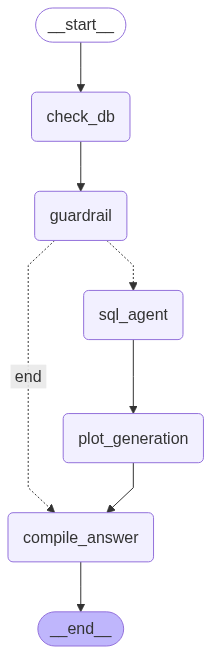

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
agent = create_sql_analysis_agent()
display(Image(agent.get_graph().draw_mermaid_png()))



🔥 STREAMING EXECUTION:
🚀 Starting SQL Analysis Agent with Streaming...
📝 User Query: Show me distribution of male and female?

🔄 STEP: CHECK_DB
----------------------------------------
📊 Checking database structure...
   Tables found: ['records']
   Summary: The database contains information about records, including survival status, passenger class, sex, age, and other details related to the passengers.
   ⏱️  Step completed

🔄 STEP: GUARDRAIL
----------------------------------------
🛡️  Running guardrail check...
   Can answer query: True
   Reason: The database contains the 'sex' column in the 'records' table, which can be used to determine the distribution of male and female.
   ⏱️  Step completed

🔄 STEP: SQL_AGENT
----------------------------------------
🔍 Generating and executing SQL query...
   Generated SQL: SELECT sex, count(*) FROM records GROUP BY sex
   Answer: There are 314 females and 577 males.
   ⏱️  Step completed


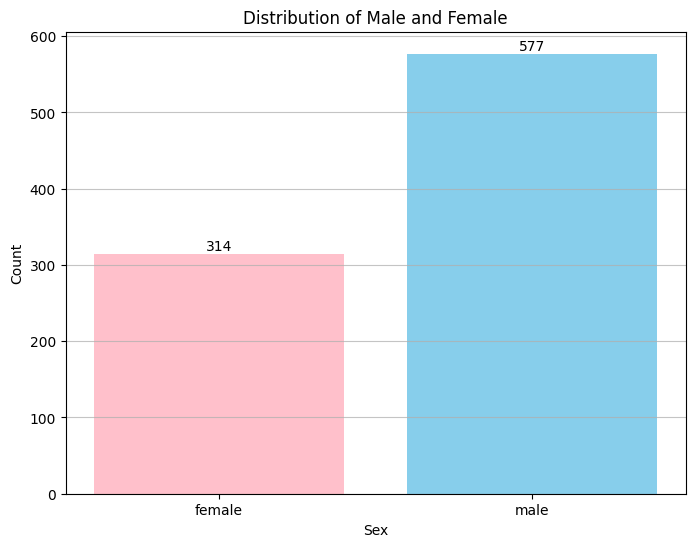


🔄 STEP: PLOT_GENERATION
----------------------------------------
📈 Generating plots and saving files...
   CSV saved to: results_data.csv
   Plot saved to: analysis_plot.png
   Plot description: The plot shows the distribution of male and female individuals. The x-axis represents the sex (male and female), and the y-axis represents the count o...
   ⏱️  Step completed

🔄 STEP: COMPILE_ANSWER
----------------------------------------
📋 Compiling final answer...
   ✅ Final answer compiled successfully!
   ⏱️  Step completed

🎉 AGENT EXECUTION COMPLETED!


In [ ]:
user_query = "Show me distribution of male and female?"
result_streaming = run_sql_analysis_with_streaming(user_query)

In [ ]:
pd.read_csv("/content/results_data.csv")

,sex,count
0,female,314
1,male,577


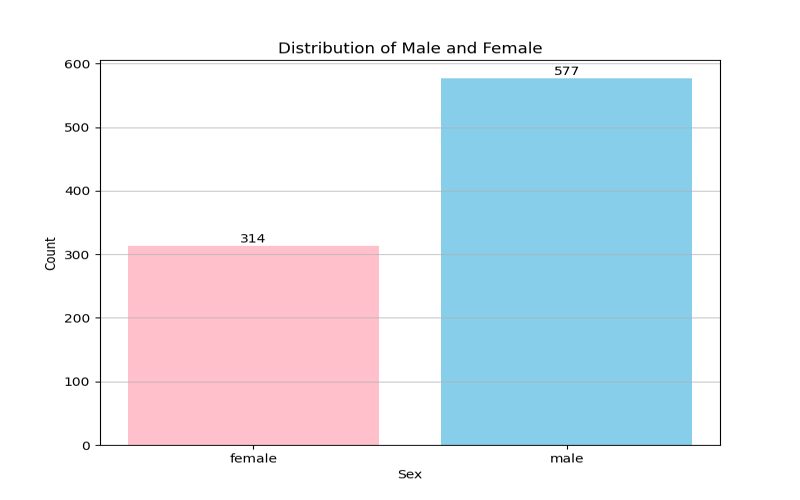

In [ ]:
from PIL import Image
image_path = "/content/analysis_plot.png"
Image.open(image_path).resize((800, 500))

🚀 Starting SQL Analysis Agent with Streaming...
📝 User Query: Show me ratio of survival vs non survival?

🔄 STEP: CHECK_DB
----------------------------------------
📊 Checking database structure...
   Tables found: ['records']
   Summary: The database contains information about records, including survival status, passenger class, sex, age, and other details related to the Titanic.
   ⏱️  Step completed

🔄 STEP: GUARDRAIL
----------------------------------------
🛡️  Running guardrail check...
   Can answer query: True
   Reason: The table 'records' contains the 'survived' column, which is relevant to the query about survival.
   ⏱️  Step completed

🔄 STEP: SQL_AGENT
----------------------------------------
🔍 Generating and executing SQL query...
   Generated SQL: SELECT SUM(CASE WHEN survived = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) FROM records
   Answer: The survival rate is approximately 38.38%.
   ⏱️  Step completed

🔄 STEP: PLOT_GENERATION
----------------------------------------
📈 G

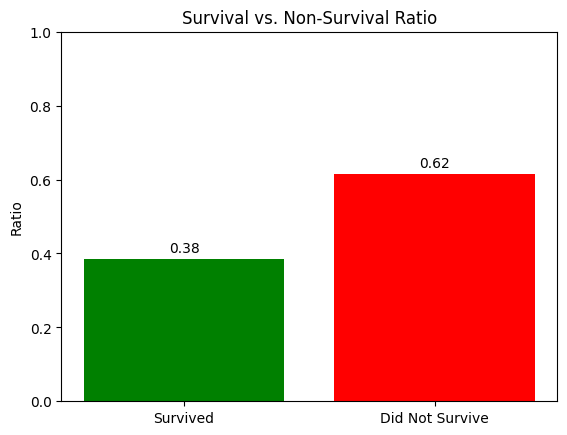

In [ ]:
user_query = "Show me ratio of survival vs non survival?"
result_streaming = run_sql_analysis_with_streaming(user_query)

In [ ]:
pd.read_csv("/content/results_data.csv")

,Unnamed: 0,Survival Ratio
0,Survived,0.383838
1,Did Not Survive,0.616162


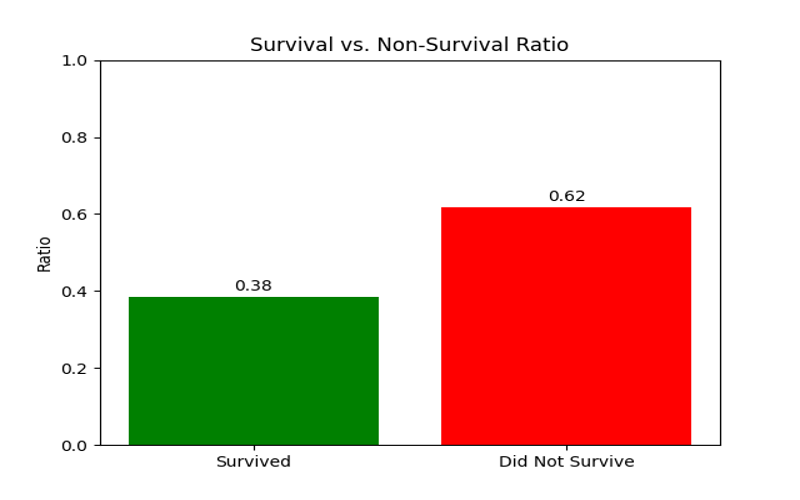

In [ ]:
Image.open(image_path).resize((800, 500))

In [ ]:
user_query = "Show me how many reviews were positive and how many negative?"
result_streaming = run_sql_analysis_with_streaming(user_query)

🚀 Starting SQL Analysis Agent with Streaming...
📝 User Query: Show me how many reviews were positive and how many negative?

🔄 STEP: CHECK_DB
----------------------------------------
📊 Checking database structure...
   Tables found: ['records']
   Summary: The database contains information about records, including survival, passenger class, sex, age, and other details. The data seems to be related to a specific event, possibly a ship manifest.
   ⏱️  Step completed

🔄 STEP: GUARDRAIL
----------------------------------------
🛡️  Running guardrail check...
   Can answer query: False
   Reason: The database does not contain information about reviews or sentiment analysis. The available data is related to passenger information and survival on a ship.
   ❌ Feedback: I am sorry, I cannot fulfill this request. The database does not contain any information about reviews or sentiment analysis. I can only provide information about passenger data, such as survival, age, and other details related 

In [ ]:
result_streaming['final_answer']

'I am sorry, I cannot fulfill this request. The database does not contain any information about reviews or sentiment analysis. I can only provide information about passenger data, such as survival, age, and other details related to the records provided. '

🚀 Starting SQL Analysis Agent with Streaming...
📝 User Query: Show me relation of age and survival?

🔄 STEP: CHECK_DB
----------------------------------------
📊 Checking database structure...
   Tables found: ['records']
   Summary: The database contains information about records, including survival, passenger class, sex, age, and other details related to the passengers.
   ⏱️  Step completed

🔄 STEP: GUARDRAIL
----------------------------------------
🛡️  Running guardrail check...
   Can answer query: True
   Reason: The database contains the 'records' table, which includes 'age' and 'survived' columns, allowing analysis of the relationship between age and survival.
   ⏱️  Step completed

🔄 STEP: SQL_AGENT
----------------------------------------
🔍 Generating and executing SQL query...
   Generated SQL: SELECT survived, AVG(age) FROM records GROUP BY survived
   Answer: The average age of those who did not survive was approximately 30.63, while the average age of those who survived wa

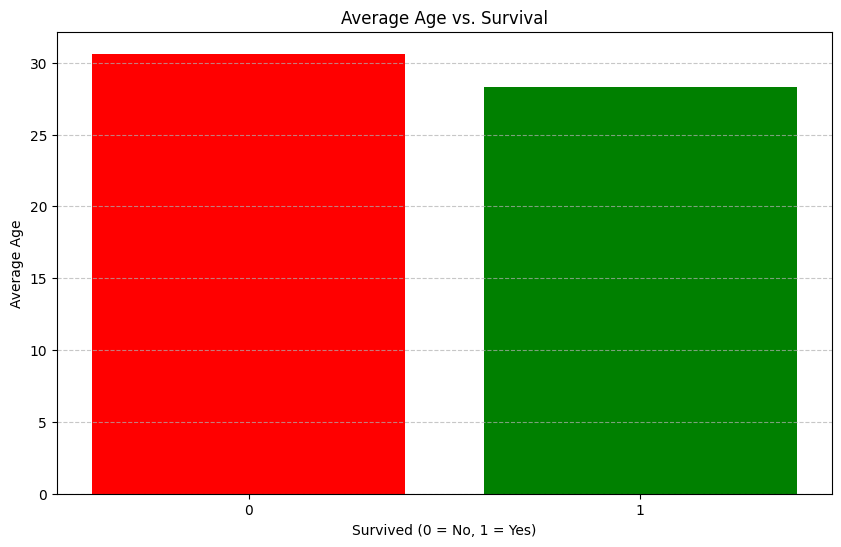


🔄 STEP: PLOT_GENERATION
----------------------------------------
📈 Generating plots and saving files...
   CSV saved to: results_data.csv
   Plot saved to: analysis_plot.png
   Plot description: The plot shows the relationship between age and survival, comparing the average age of passengers who did not survive (0) and those who survived (1).
   ⏱️  Step completed

🔄 STEP: COMPILE_ANSWER
----------------------------------------
📋 Compiling final answer...
   ✅ Final answer compiled successfully!
   ⏱️  Step completed

🎉 AGENT EXECUTION COMPLETED!


In [ ]:
user_query = "Show me relation of age and survival?"
result_streaming = run_sql_analysis_with_streaming(user_query)

In [ ]:
print(result_streaming['final_answer'])


        **Answer:** The average age of those who did not survive was approximately 30.63, while the average age of those who survived was approximately 28.34.

        **SQL Query Used:** SELECT survived, AVG(age) FROM records GROUP BY survived

        **Generated Files:**
        - Results CSV: results_data.csv
        - Plot: analysis_plot.png

        **Plot Description:** The plot shows the relationship between age and survival, comparing the average age of passengers who did not survive (0) and those who survived (1).
        


In [ ]:
pd.read_csv("/content/results_data.csv")

,survived,avg_age
0,0,30.626179
1,1,28.343690


🚀 Starting SQL Analysis Agent with Streaming...
📝 User Query: Show me relation of gender and survival?

🔄 STEP: CHECK_DB
----------------------------------------
📊 Checking database structure...
   Tables found: ['records']
   Summary: The database contains information about records, including survival status, passenger class, sex, age, and other details related to the passengers.
   ⏱️  Step completed

🔄 STEP: GUARDRAIL
----------------------------------------
🛡️  Running guardrail check...
   Can answer query: True
   Reason: The database contains a table 'records' with columns 'sex' and 'survived' which are relevant to the user's query.
   ⏱️  Step completed

🔄 STEP: SQL_AGENT
----------------------------------------
🔍 Generating and executing SQL query...
   Generated SQL: SELECT sex, SUM(survived) AS survived_count, COUNT(*) - SUM(survived) AS not_survived_count FROM records GROUP BY sex
   Answer: The survival rate varied by gender. Out of the females, 233 survived and 81 did not

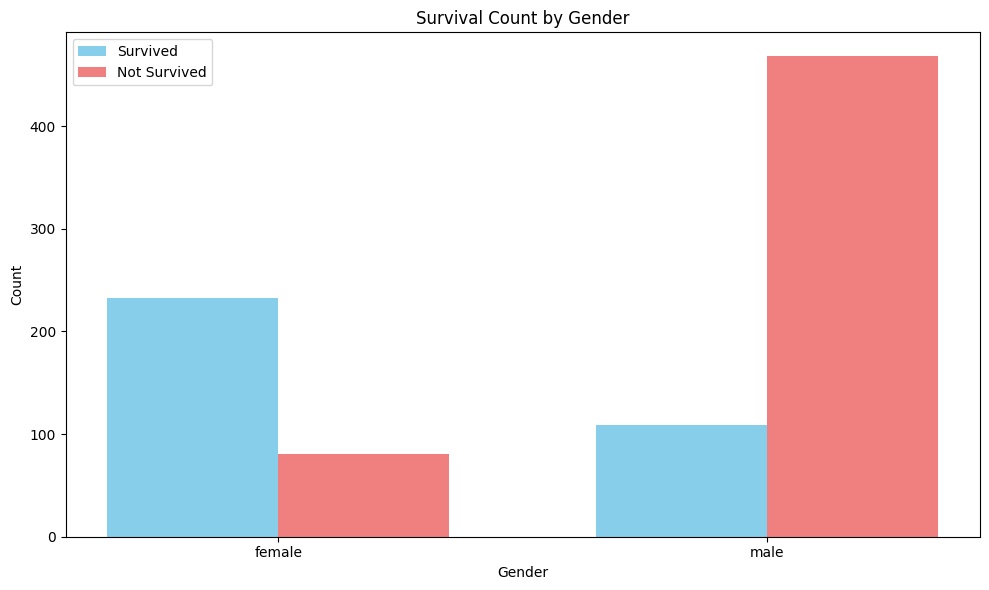


🔄 STEP: PLOT_GENERATION
----------------------------------------
📈 Generating plots and saving files...
   CSV saved to: results_data.csv
   Plot saved to: analysis_plot.png
   Plot description: The plot visualizes the relationship between gender and survival on the Titanic. It displays the number of survivors and non-survivors for each gender...
   ⏱️  Step completed

🔄 STEP: COMPILE_ANSWER
----------------------------------------
📋 Compiling final answer...
   ✅ Final answer compiled successfully!
   ⏱️  Step completed

🎉 AGENT EXECUTION COMPLETED!


In [ ]:
user_query = "Show me relation of gender and survival?"
result_streaming = run_sql_analysis_with_streaming(user_query)

In [ ]:
pd.read_csv("/content/results_data.csv")

,sex,survived_count,not_survived_count
0,female,233,81
1,male,109,468


🚀 Starting SQL Analysis Agent with Streaming...
📝 User Query: Show me what is my survival chance if i am female with age 18?

🔄 STEP: CHECK_DB
----------------------------------------
📊 Checking database structure...
   Tables found: ['records']
   Summary: The database contains information about records, including survival status, passenger class, sex, age, sibling/spouse and parent/child relationships, fare, embarkation details, class, who, adult male status, deck, embarkation town, alive status, and whether the passenger was alone.
   ⏱️  Step completed

🔄 STEP: GUARDRAIL
----------------------------------------
🛡️  Running guardrail check...
   Can answer query: True
   Reason: The database contains information about survival, sex, and age, which are the required columns to answer the question.
   ⏱️  Step completed

🔄 STEP: SQL_AGENT
----------------------------------------
🔍 Generating and executing SQL query...
   Generated SQL: SELECT SUM(CASE WHEN survived = 1 THEN 1 ELSE 0 EN

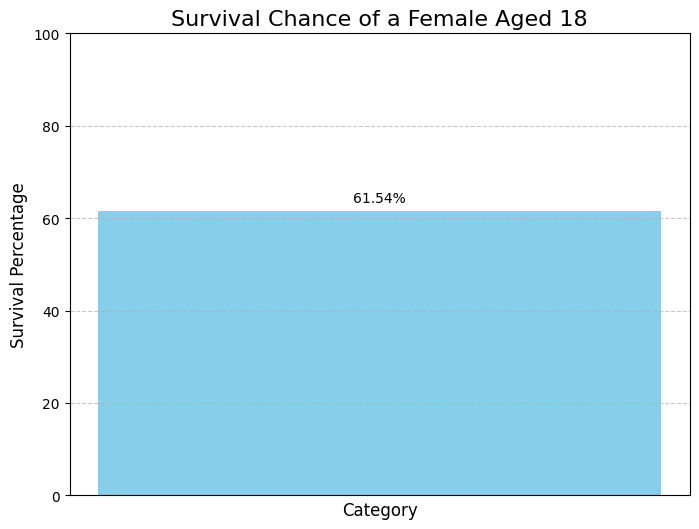

In [ ]:
user_query = "Show me what is my survival chance if i am female with age 18?"
result_streaming = run_sql_analysis_with_streaming(user_query)

In [ ]:
pd.read_csv("/content/results_data.csv")

,Survival Chance
0,61.538462


In [ ]:
print(result_streaming['final_answer'])


        **Answer:** The survival chance for a female aged 18 is approximately 61.54%.

        **SQL Query Used:** SELECT SUM(CASE WHEN survived = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) FROM records WHERE sex = 'female' AND age = 18

        **Generated Files:**
        - Results CSV: results_data.csv
        - Plot: analysis_plot.png

        **Plot Description:** The plot shows the survival chance of a female aged 18. The key insight is that the survival chance for this demographic is approximately 61.54%.
        
